# City of Boston Payroll Analysis - Part 1: Data Cleaning
Salary data is available for City of Boston employees from at least 2011 to 2017.  Roughly 20,000 employees and salaries are classified by department, job title, “regular” or “overtime”, zip code and a few other criteria.

In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-colorblind')
# sns.set()

## Read data, and basic fixes

In [2]:
# read file(s)
path = os.getcwd()                    
all_files = glob.glob(os.path.join(path, "employee*.csv"))  

column_names = ['name', 'department', 'title', 'regular', 'retro', 'other', 'overtime', 'injured',\
                'detail', 'quinn', 'total', 'zip']
df_from_each_file = (pd.read_csv(f, delimiter=',', encoding = "ISO-8859-1", header=0, names=column_names, \
                                 index_col=None).assign(year=f) for f in all_files)  # read year from filename 
earnings   = pd.concat(df_from_each_file, ignore_index=True)

A complete set of names/employees, departments, titles and total earnings are availble for the years 2011-2017. Some fields are blank due to no earnings in that particular category. Number columns are given as strings with preceding "$" symbol. Cells are blank where no earnings are reported. 8 zipcodes are missing. The basic cleaning steps are:

- Extract year from path (filename of earnings report) and assign to new column "year"
- Columns "department" and "title" are in reverse order for 2013 and 2014
- Zipcodes are 5 digits for some years, 5 + 4 for other years and only 4 digits in 2017 where the leading "0" has been dropped
- Missing zipcodes can be filled by comparing to previous year's employee entry
- Add checkpoint to confirm complete set of 5 digit zipcodes
- Replace empty number cells with "0"
- Convert all numbers to numeric dtype

In [3]:
# extract year from filename
earnings['year'] = earnings['year'].replace({'\D':''}, regex=True) 
earnings['year'] = earnings['year'].str[-4:]  # remove any numbers from file path

# switch "department" and "title" columns for 2013 and 2014
earnings.loc[earnings.year.isin(['2013', '2014']),['department','title']] = \
        earnings.loc[earnings.year.isin(['2013', '2014']),['title','department']].values
    
# add leading zero for 4 digit zip codes
earnings['zip'] = np.where(earnings['zip'].str.len() == 4, '0' + earnings['zip'], earnings['zip'])

# missing zip codes
earnings.loc[earnings['zip'].str.len() < 4, 'zip'] = np.NaN
earnings['zip'] = earnings.sort_values(by='name')['zip'].fillna(method='ffill')

# ignore "+4" zip codes
earnings['zip'] = earnings['zip'].str[:5]

# convert number strings to numeric dtype
number_columns = ['regular', 'retro', 'other', 'overtime', 'injured', 'detail', 'quinn', 'total']
earnings[number_columns] = earnings[number_columns].replace({'\$': '', ',': ''}, regex=True)\
                                .apply(pd.to_numeric, errors='coerce').fillna(0, axis=1)

## Consolidate department names

There are roughly 1400 unique job titles - a plausible number. Interestingly there is a sharp increase in department names between 2013 and 2014. The city's website lists 72 departments. This appears to be due to a detailed breakdown of the public school department.

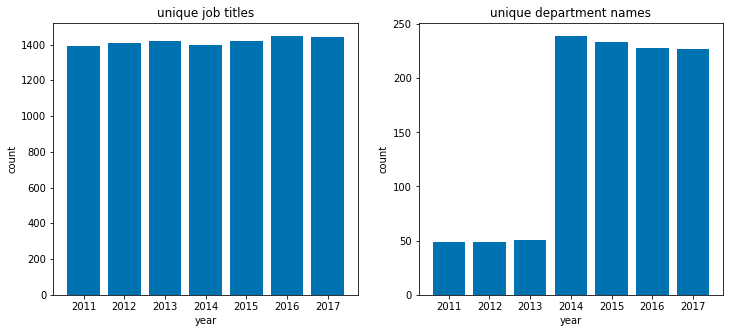

In [4]:
# unique job titles and departments by year
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(earnings['year'].unique(), earnings.groupby('year')['title'].nunique())
ax1.set_title('unique job titles')
ax1.set_ylabel('count')
ax1.set_xlabel('year')

ax2.bar(earnings['year'].unique(), earnings.groupby('year')['department'].nunique())
ax2.set_title('unique department names')
ax2.set_ylabel('count')
ax2.set_xlabel('year')

plt.show()

In [5]:
# combine all school departments into a single "Boston Public Schools" department

earnings['dept_clean'] = earnings['department'] # all others to stay the same
earnings['dept_clean'] = np.where(earnings.department.astype(str).str[:3] == \
                                  'BPS', 'Boston Public Schools', earnings.dept_clean)
earnings['dept_clean'] = np.where(earnings.department.astype(str).str[:10] == \
                                  'Asst Super', 'Boston Public Schools', earnings.dept_clean)

bps = ['K-8', 'EEC', 'ELC', 'Middle', 'School', 'Academy', 'Elementary', 'Greenwood', 
       'E Leadership Acad', 'UP Academy Dorchester', 'UP "Unlocking Potential" Acad', 
       'Lyon Pilot High 9-12', 'Ellison/Parks EES', 'Chief Academic Officer', 
       'UP Academy Holland', 'Achievement Gap', 'English Language Learn', 'Haley Pilot',
       'Greater Egleston High', 'Early Learning Services', 'Career & Technical Ed', 
       'Teaching & Learning', 'Unified Student Svc', 'Superintendent',
       'Student Support Svc', 'Harbor High', 'Fam & Student Engagemt', 
       'Enrollment Services', 'Food & Nutrition Svc', 'HPEC: Com Acd Science & Health',
       'Institutional Advancemt', 'Legal Advisor', 'Professional Developmnt', 
       'Chief Operating Officer', 'Research Assess & Eval', 'Info & Instr Technology',
       'BTU Pilot', 'Boston Collaborative High Sch', 'Diplomas Plus', 'Chief Financial Officer']
for i in bps:
    earnings['dept_clean'] = np.where(earnings.department.astype(str).str[-len(i):] == \
                                      i, 'Boston Public Schools', earnings.dept_clean)


New departments in 2017:

In [6]:
print(set(earnings.dept_clean.loc[earnings.year == '2017'].unique()) - \
      set(earnings.dept_clean.loc[earnings.year == '2016'].unique()))

{'Advancement & Ext. Affairs', 'Chief of Staff'}


Further consolidation of departments would be difficult without further information from the city. Taking a look at the department sizes from year to year shows a number of department name changes. These will be adjusted using the 2017 names.

In [7]:
# miscellaneous departments - mostly name changes over time:
dept_names = {'Transportation Department': 'Traffic Division',
              'Dept of Voter Mobilization': 'Election Division',
              'State Boston Retirement Syst': 'Boston Retirement System',
              'Youth Fund': 'Youth Engagement & Employment',
              'Administration and Finance': 'Office of Admin & Finance',
              'Office of Finance & Budget': 'Office of Admin & Finance',
              'Office Of Civil Rights': 'Fair Housing & Equity',
              'Small & Local Business': 'Office of Economic Development',
              'Ofc Chf Public Works Transport': 'Office of Streets',
              'Ofc of Strts, Trnsp & Sani': 'Office of Streets',
              'Property Management': 'Public Facilities Department',
              'Mayor\'s Office-Public Info': 'Mayor\'s Office',
              'Arts & Cultural Development': 'Office of Arts & Culture',
              'Accountability': 'Licensing Board',
              'Women\'s Commission': 'Women\'s Advancement'}
for k in dept_names:
    earnings['dept_clean'] = np.where(earnings.department.str[-len(k):] == \
                                 k, dept_names[k], earnings.dept_clean)


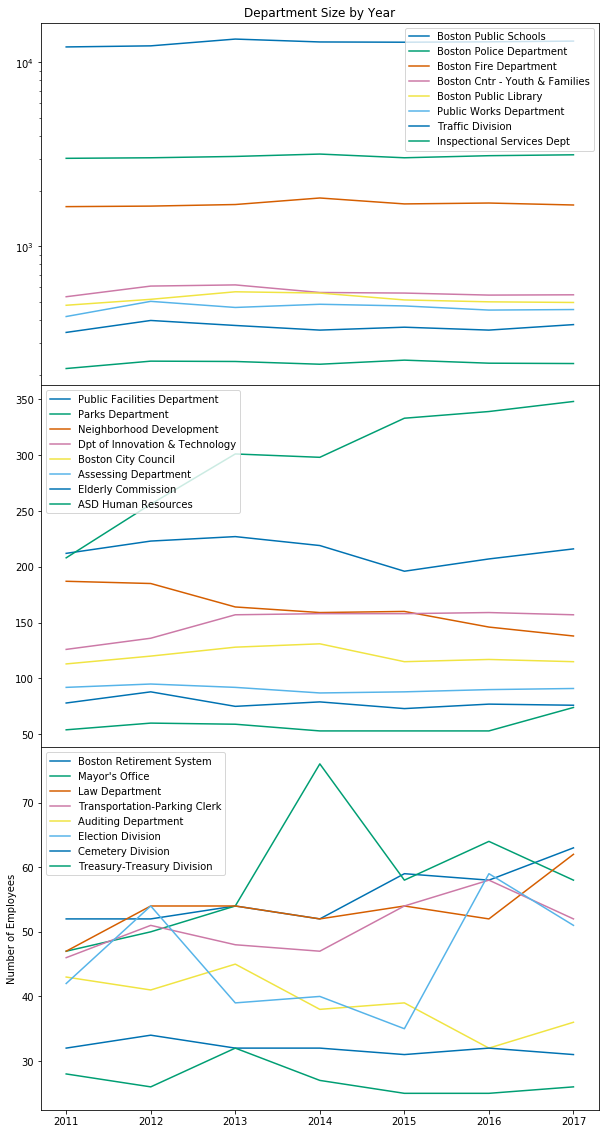

In [8]:
# pivot to obtain number of employees in each department by year
depts = pd.pivot_table(earnings, values='name', index='dept_clean',  columns='year', aggfunc='count')

# extract the n largest departments by given year
lg_depts = depts.sort_values('2011', ascending=False).fillna(0).iloc[:8]
md_depts = depts.sort_values('2011', ascending=False).fillna(0).iloc[8:16]
sm_depts = depts.sort_values('2011', ascending=False).fillna(0).iloc[16:24]

# plot department size over year
lt_depts = pd.DataFrame.transpose(lg_depts)
mt_depts = pd.DataFrame.transpose(md_depts)
st_depts = pd.DataFrame.transpose(sm_depts)

x = lt_depts.index

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 20), sharex=True)
ax1.set_title('Department Size by Year')
ax1.plot(x, lt_depts)
ax1.set_yscale('log')
ax1.legend(lt_depts)
ax2.plot(x, mt_depts)
ax2.legend(mt_depts)
ax3.plot(x, st_depts)
ax3.legend(st_depts)
ax3.set_ylabel('Number of Employees')

fig.subplots_adjust(hspace=0)

plt.show()

Increased variance in the lower chart can be explained by the small number of employees where a small change can have a bigger impact. Nonetheless it could be interesting to look at the spike in the mayor's office in 2014 - mayor Marty Walsh's first year in office. Another interesting observation is the spike in the election division in the presidential election years 2012 and 2016.

## Consolidate Job Titles

A closer look at the job titles shows some data cleaning might be helpful as well. Fortunately the school department titles look reasonably clean, however the police, fire and library departments could use some work. The Pareto rule will be applied again to limit further investigation of job titles.

### Police Department Titles

Below is an example of inconsistent entries in the titles field. The "$" symbols at the end appear to be errors and don't affect the rest of the data.

In [9]:
# police titles:
police_titles = earnings.loc[(earnings.department == 'Boston Police Department')\
                            & (earnings.title.str.startswith('Police O'))\
                            & (earnings.year == '2017')]\
                            ['title'].value_counts()
print(police_titles)

Police Officer                    1331
Police Offc Comm Serv Offc 3$8      51
Police Offc Mobile Offc 2$6         42
Police Offc Acad Instr 2$6          29
Police Offc/FgrPrt Ev Tch 4$10      25
Police Offc/Juvenile Offc 4$10      19
Police Offc Canine 2$6              17
Police Officer Hdq Dispatch         16
Police Offc Harborboat 3$8          14
Police Offc Hackney Invest 3$8      14
Police Offc/Auto Invest 4$10        12
Police Offc/Bomb Squad              11
Police Offc Ballistician 4$10        8
Police Offc Canine Offc 2$6          8
Police Offc Bomb Squad               7
Police Offc/Hosp Liaison 4$10        5
Police Officer Harborboat 3$8        4
Police Officer Mobile Oper 2$6       2
Police Offc Breath $13.50            1
Name: title, dtype: int64


In [10]:
"""
More information can be found here:
https://en.wikipedia.org/wiki/Boston_Police_Department#Departmental_organization

"""

# consolidate police department titles

earnings['title_clean'] = earnings['title'] # all others to stay the same
pol = {'Police Of': 'Police Officer', 
        'Police Se': 'Police Sergeant',
        'PoliceSer': 'Police Sergeant',
        'Police Li': 'Police Lieutenant',
        'Police Ca': 'Police Captain',
        'Police Li': 'Police Lieutenant'}
for k in pol:
    earnings['title_clean'] = np.where(earnings.title.str[:9] == k, pol[k], earnings.title_clean)

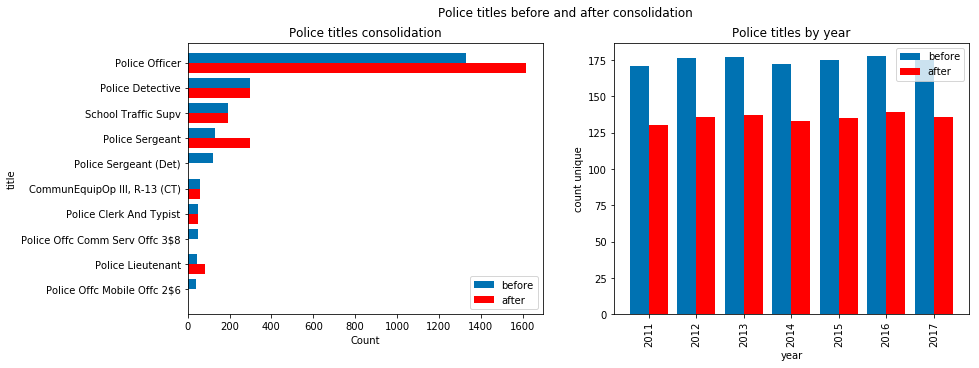

In [11]:
# Display before and after stats

police_titles_before = earnings['title'].loc[(earnings.department == 'Boston Police Department') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
police_titles_after = earnings['title_clean'].loc[(earnings.department == 'Boston Police Department') \
                                        & (earnings.year == '2017')] \
                                        .value_counts() \
                                        .nlargest(10) \
                                        .reset_index() 
    
police_join = pd.merge(police_titles_before, police_titles_after, how='left') \
                        .fillna(0) \
                        .sort_values(by=['title'], ascending=False) \
                        .rename(index=str, columns={'index': 'title', 'title': 'before', 'title_clean': 'after'})
            
titles_by_year = pd.pivot_table(earnings[earnings['dept_clean'] == 'Boston Police Department'],\
                            values=['title', 'title_clean'], columns='year', aggfunc=pd.Series.nunique) \
                            .sort_values(by='2017', ascending=False)[:10] \
                            .transpose() \
                            .reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('Police titles before and after consolidation')

police_join.plot('title', 'before', kind='barh', ax=ax1, width=0.4, position=1).invert_yaxis()
police_join.plot('title', 'after', kind='barh', ax=ax1, width=0.4, color='r', position=0).invert_yaxis()
ax1.set_title('Police titles consolidation')
ax1.set_xlabel('Count')
ax1.set_ylim(10, -0.8)

titles_by_year.plot('year', 'title', kind='bar', ax=ax2, width=0.4, position=1, label='before')
titles_by_year.plot('year', 'title_clean', kind='bar', ax=ax2, width=0.4, color='r', position=0, label='after')
ax2.set_title('Police titles by year')
ax2.set_xlabel('year')
ax2.set_ylabel('count unique')
plt.autoscale(tight=False)

plt.show()


### Fire Department Titles

In [12]:
# consolidate fire department titles

fd = {'FF': 'Fire Fighter', 
      'Fire Fi': 'Fire Fighter',
      'FireFig': 'Fire Fighter',
      'Fire Ca': 'Fire Captain',
      'Fire L': 'Fire Lieutenant',
      'FireLi': 'Fire Lieutenant',
      'Distric': 'District Fire Chief',
      'Dist Fi': 'District Fire Chief',
      'DistFCh': 'District Fire Chief',
      'Dep Fir': 'Dep Fire Chief',
      'DepFire': 'Dep Fire Chief'}

for k in fd:
    earnings['title_clean'] = np.where(earnings.title.astype(str).str[:len(k)] == k, fd[k], earnings.title_clean)

earnings['title_clean'] = np.where((earnings.title.str[:10] == 'Sr Admin A') \
                                   & (earnings.dept_clean == 'Boston Fire Department'),\
                                   'Sr Admin (Fire)', earnings.title_clean)

fd_titles = earnings.title_clean.loc[(earnings.dept_clean == 'Boston Fire Department')]
print('Number of unique job titles in fire department:', len(set(fd_titles)))
print(fd_titles.value_counts().nlargest(10))

Number of unique job titles in fire department: 104
Fire Fighter                      7971
Fire Lieutenant                   1605
Fire Captain                       545
District Fire Chief                390
Fire Alarm Operator                144
Sr Admin (Fire)                    122
Dep Fire Chief                     117
Head Clerk                          77
Hvy Mtr Equip Repairperson BFD      45
Sr Fire Alarm Operator              43
Name: title_clean, dtype: int64


### Library titles

In [13]:
library = {'Spec Library Asst': 'Spec Library Asst',
       'Sr Library Asst': 'Sr Library Asst',
       'Librarian': 'Librarian',
       'Special Library': 'Spec Library Asst',
       'Spec Collection L': 'Librarian',
       'Collection Libr': 'Librarian'}
for k in library:
    earnings['title_clean'] = np.where(earnings.title.str.contains(k), library[k], earnings.title_clean)

bpl_titles = earnings.title_clean.loc[(earnings.dept_clean == 'Boston Public Library')]
print('Number of unique job titles in Boston Public Library:', len(set(bpl_titles)))
print(bpl_titles.value_counts().nlargest(20))

Number of unique job titles in Boston Public Library: 149
Librarian                         781
Spec Library Asst                 575
Sr Library Asst                   564
Library Aide                      504
Sr Bldg Custodian                 154
Jr Building Custodian             100
Prin Library Asst                  45
Generalist II                      40
Technical Support Associate        30
Curator-Professional Lib IV        28
Generalist I                       27
Sr Clerk                           23
Cataloger And Classifier I         22
Laborer                            21
Cataloger And Classifier II        20
Asst Neighborhood Services Mgr     19
Technical Specialist               18
Programs & Comm Outreach Libr      18
Clerk                              15
Staff Officer-Special Projects     15
Name: title_clean, dtype: int64


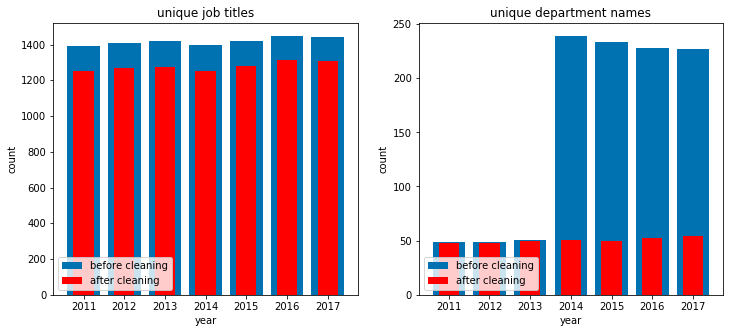

In [14]:
# unique job titles and departments by year
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(earnings['year'].unique(), earnings.groupby('year')['title'].nunique(), label='before cleaning')
ax1.bar(earnings['year'].unique(), earnings.groupby('year')['title_clean'].nunique(), color='r', width=0.5, label='after cleaning')
ax1.set_title('unique job titles')
ax1.set_ylabel('count')
ax1.set_xlabel('year')
ax1.legend(loc=3)

ax2.bar(earnings['year'].unique(), earnings.groupby('year')['department'].nunique(), label='before cleaning')
ax2.bar(earnings['year'].unique(), earnings.groupby('year')['dept_clean'].nunique(), color='r', width=0.5, label='after cleaning')
ax2.set_title('unique department names')
ax2.set_ylabel('count')
ax2.set_xlabel('year')
ax2.legend(loc=3)

plt.show()

In [15]:
# save combined data to file
earnings.to_csv('earnings.csv')